In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from matplotlib.pyplot import cm
from scipy import signal
from scipy.signal import find_peaks


In [6]:
# Set the style of the plots to a more beautiful format
az.style.use('arviz-whitegrid')

In [37]:
# Initializam parametrii
# parametrul nu 
nu = 0.0292
# Spatiul pe care facem integrarea
L = 2 * np.pi
# Numarul de pasi spatiali
nx = 8192

# Timpul [0,7] cu pas dt = 0.0005
t0 = 0 
tN = 7
dt = 0.0005
# Numarul de pasi
nt = int((tN - t0) / dt)

# numarul de unda 
k = np.arange(-nx/2, nx/2, 1)

# Initializam gridul spatio-temporal
t = np.linspace(start=t0, stop=tN, num=nt)
x = np.linspace(start=0, stop=L, num=nx)

# solution mesh in real space
u = np.ones((nx, nt))
# solution mesh in Fourier space
u_hat = np.ones((nx, nt), dtype=complex)

u_hat2 = np.ones((nx, nt), dtype=complex)

# initial condition 
#u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)
u0 = - np.sin(x)

# Fourier transform of initial condition
u0_hat = (1 / nx) * np.fft.fftshift(np.fft.fft(u0))

u0_hat2 = (1 / nx) * np.fft.fftshift(np.fft.fft(u0**2))

# set initial condition in real and Fourier mesh
u[:,0] = u0
u_hat[:,0] = u0_hat

u_hat2[:,0] = u0_hat2

# Fourier Transform of the linear operator
FL = (((2 * np.pi) / L) * k) ** 2 - nu * (((2 * np.pi) / L) * k) ** 4
# Fourier Transform of the non-linear operator
FN = - (1 / 2) * ((1j) * ((2 * np.pi) / L) * k)


In [38]:

# resolve EDP in Fourier space
for j in range(0,nt-1):
  uhat_current = u_hat[:,j]
  uhat_current2 = u_hat2[:,j]
  if j == 0:
    uhat_last = u_hat[:,0]
    uhat_last2 = u_hat2[:,0]
  else:
    uhat_last = u_hat[:,j-1]
    uhat_last2 = u_hat2[:,j-1]
  
  # compute solution in Fourier space through a finite difference method
  # Cranck-Nicholson + Adam 
  u_hat[:,j+1] = (1 / (1 - (dt / 2) * FL)) * ( (1 + (dt / 2) * FL) * uhat_current + ( ((3 / 2) * FN) * (uhat_current2) - ((1 / 2) * FN) * (uhat_last2) ) * dt )
  # go back in real space
  u[:,j+1] = np.real(nx * np.fft.ifft(np.fft.ifftshift(u_hat[:,j+1])))
  u_hat2[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]**2))



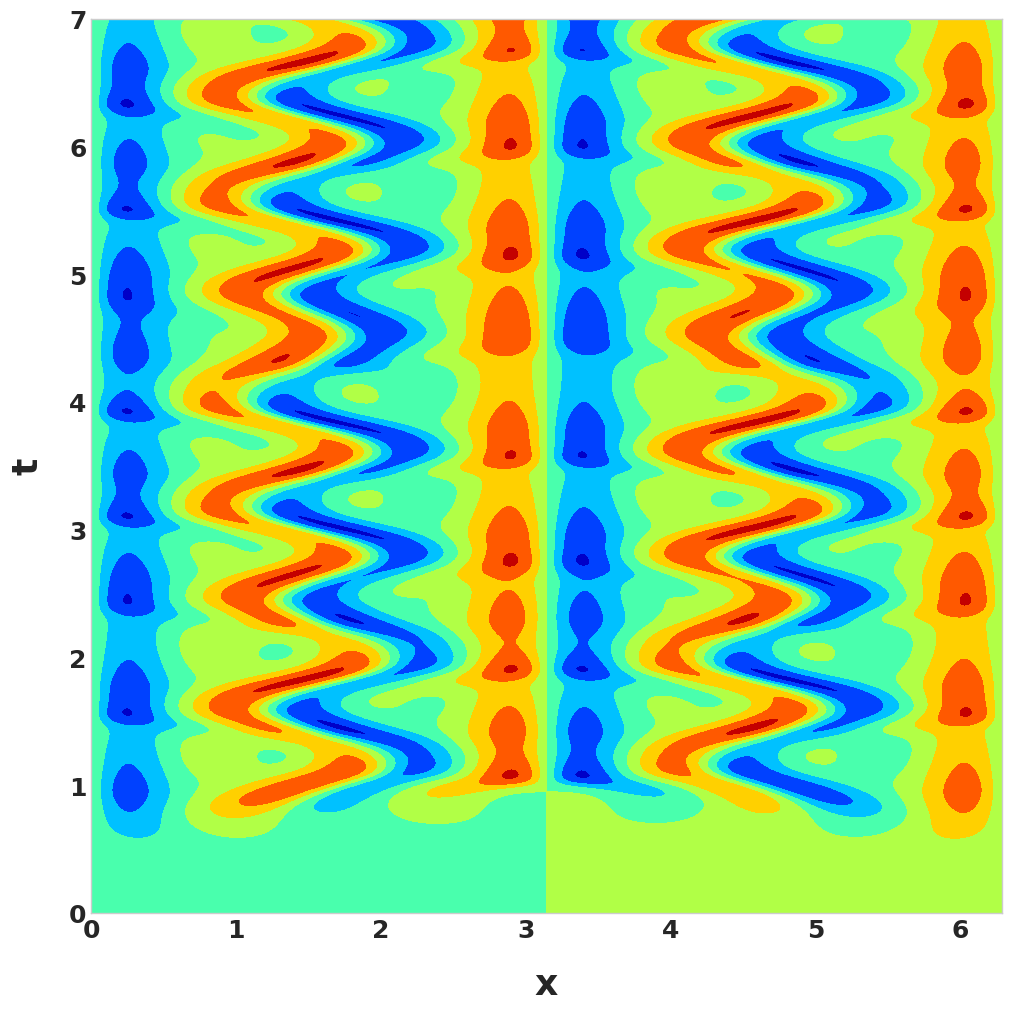

In [39]:
# plot the result
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

xx, tt = np.meshgrid(x, t)
levels = np.arange(-3, 3, 0.01)
cs = ax.contourf(xx, tt, u.T, cmap=cm.jet)
#ax.colorbar(cs)

ax.set_xlabel("x",fontsize=26, fontweight='bold', labelpad=18)
ax.set_ylabel("t",fontsize=26, fontweight='bold', labelpad=18)


plt.setp(ax.get_xticklabels(), fontsize=18, fontweight='bold')
plt.setp(ax.get_yticklabels(), fontsize=18, fontweight='bold')


#ax.axhline(linewidth=8, color='black')
#ax.axvline(linewidth=8, color='black')

plt.savefig(f'KS_chaotic2D.png',bbox_inches='tight');


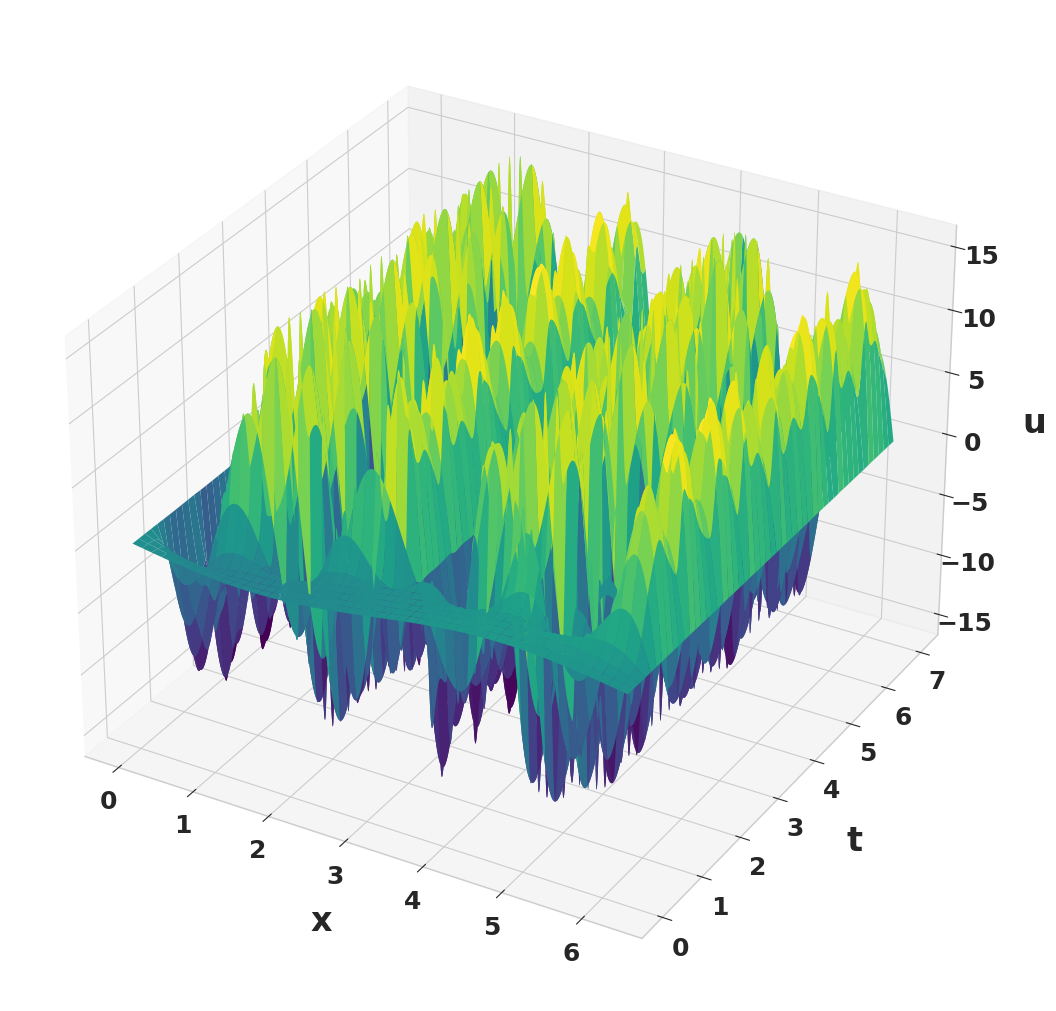

In [40]:
# plot the result
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.plot_surface(xx, tt, u.T,cmap='viridis', edgecolor='none')
ax.set_xlabel('x',fontsize=24, fontweight='bold',labelpad=18)
ax.set_ylabel('t',fontsize=24, fontweight='bold',labelpad=18)
ax.set_zlabel('u',fontsize=24, fontweight='bold',labelpad=18)
#ax.set_title(r'$\nu$'+f'={nu}',fontsize=24, fontweight='bold')

plt.setp(ax.get_xticklabels(), fontsize=18, fontweight='bold')
plt.setp(ax.get_yticklabels(), fontsize=18, fontweight='bold')
plt.setp(ax.get_zticklabels(), fontsize=18, fontweight='bold')

#plt.setp(ax.spines.values(), linewidth=5)

#plt.tight_layout()

plt.savefig(f'KS_chaotic3D.png',bbox_inches='tight');

# Plots side by side

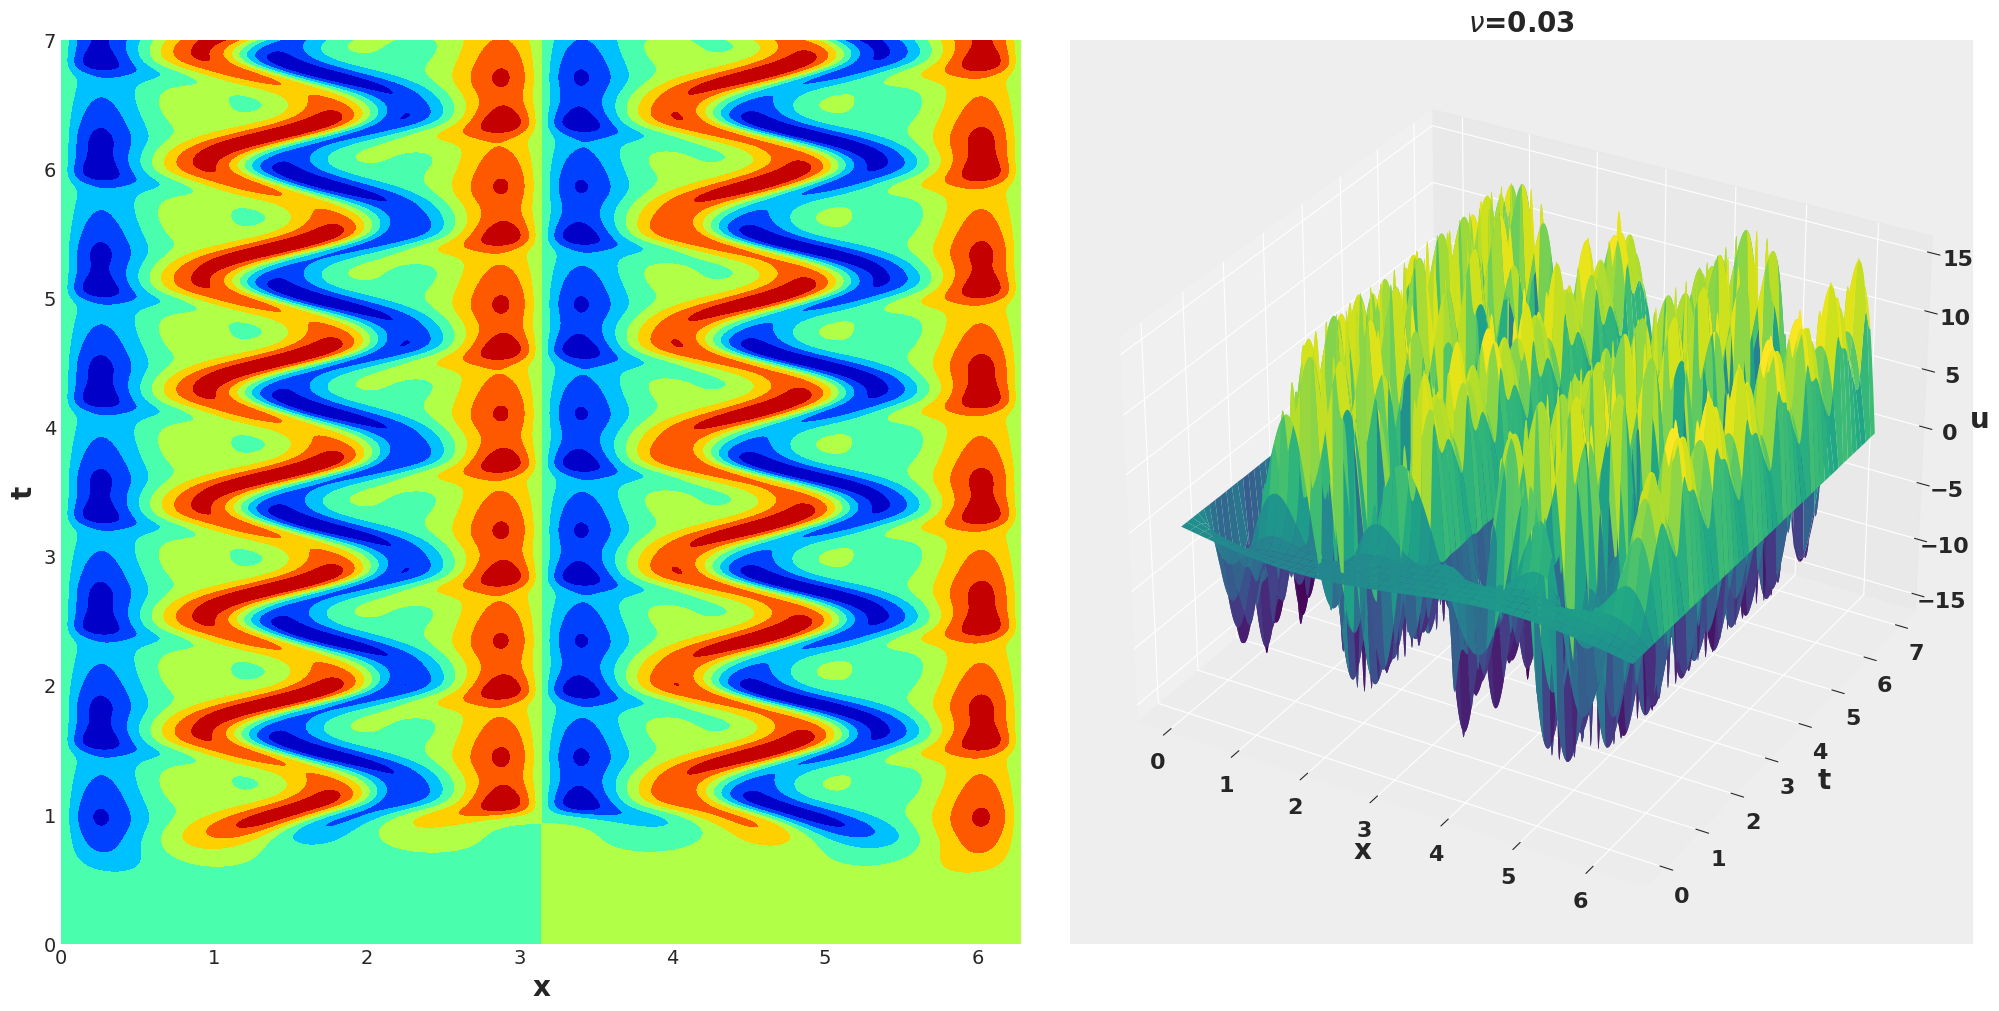

In [5]:
# plot the result
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 2, 1)

xx, tt = np.meshgrid(x, t)
levels = np.arange(-3, 3, 0.01)
cs = ax.contourf(xx, tt, u.T, cmap=cm.jet)
#ax.colorbar(cs)

ax.set_xlabel("x",fontsize=20, fontweight='bold')
ax.set_ylabel("t",fontsize=20, fontweight='bold')
#ax.set_title(f'L = {np.round(L,4)} ' +r'$\nu$' + f'={nu}')

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(xx, tt, u.T,cmap='viridis', edgecolor='none')
ax.set_xlabel('x',fontsize=20, fontweight='bold')
ax.set_ylabel('t',fontsize=20, fontweight='bold')
ax.set_zlabel('u',fontsize=20, fontweight='bold');
ax.set_title(r'$\nu$'+f'={nu}',fontsize=20, fontweight='bold')

plt.setp(ax.get_xticklabels(), fontsize=16, fontweight='bold')
plt.setp(ax.get_yticklabels(), fontsize=16, fontweight='bold')
plt.setp(ax.get_zticklabels(), fontsize=16, fontweight='bold')

#plt.tight_layout()

plt.savefig(f'KS3D_nu{nu}.png',bbox_inches='tight')

# Energy bifurcation

In [40]:
dx = L / nx

E = []
Ederiv = [0]

for j in range(0,nt):
    E.append(np.sqrt(sum(u[:,j]**2 * dx)))

#E = [100-element for element in E]
    
Ederiv[0]= E[0]
for j in range(1,nt-1):
    Ederiv.append((E[j+1]-E[j])/dt)

transit = round(nt/2)
E=E[transit:nt-1]
Ederiv=Ederiv[transit:]
t = t[transit:nt-1]

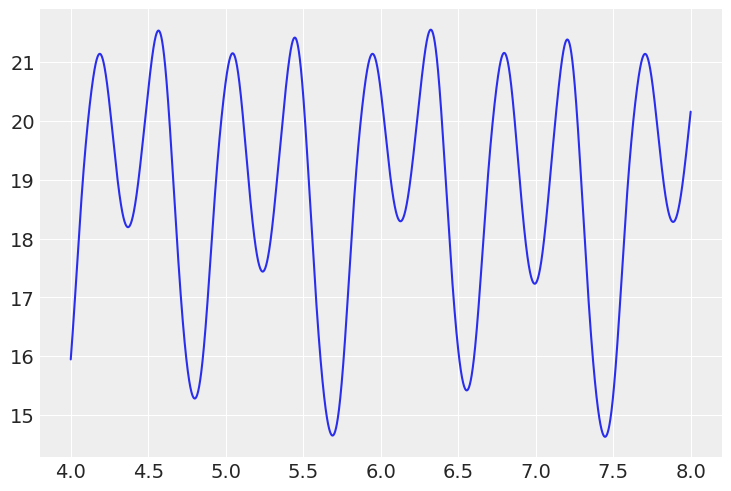

In [41]:
plt.plot(t,E)

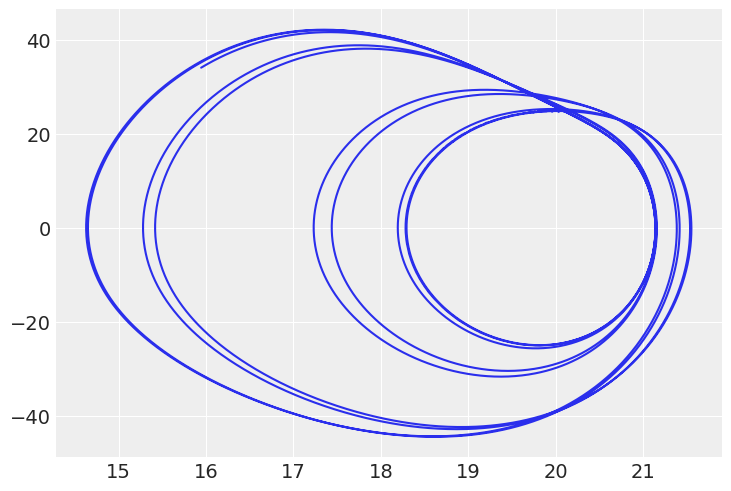

In [42]:
plt.plot(E,Ederiv)

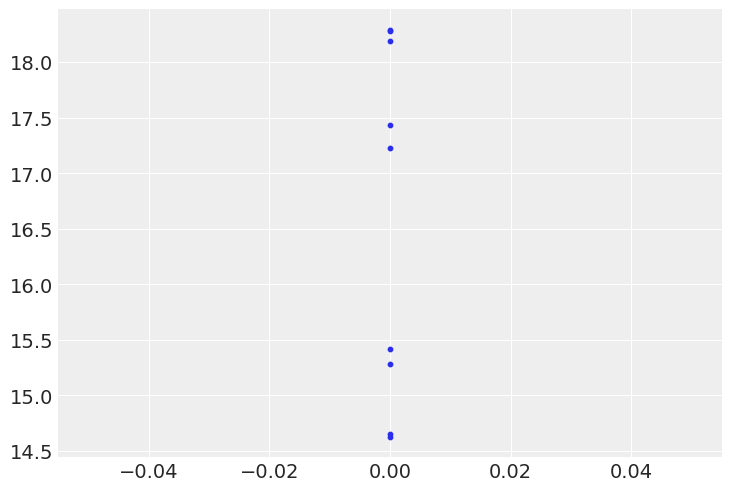

In [45]:
#peaks, _ = find_peaks(E, height=0)
E = np.array(E)
peaks = signal.argrelextrema(E, np.less)
EE = [E[element] for element in peaks]
plt.scatter(np.zeros_like(EE)*nu,EE,s=10)

In [ ]:
dx = L / nx

E2 = []
Ederiv2 = [0]

for j in range(0,nt):
    E2.append(np.sqrt( (3/8 * u[0,j]**2  + 7/6 * u[1,j]**2 + 23/24 * u[2,j]**2  + sum(u[3:nx-4,j]**2) + 23/24 * u[nx-3,j]**2 + 7/6 * u[nx-2,j]**2 + 3/8 * u[nx-1,j]**2)*dx ))
    
Ederiv2[0]= E2[0]
for j in range(1,nt-1):
    Ederiv2.append((E2[j+1]-E2[j])/dt)

transit = round(nt/2)
E2=E2[transit:nt-1]
Ederiv2=Ederiv2[transit:]

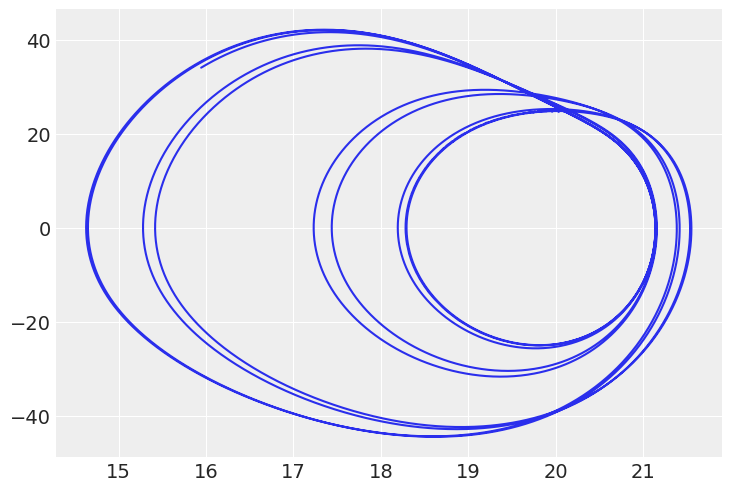

In [ ]:
plt.plot(E2,Ederiv2)

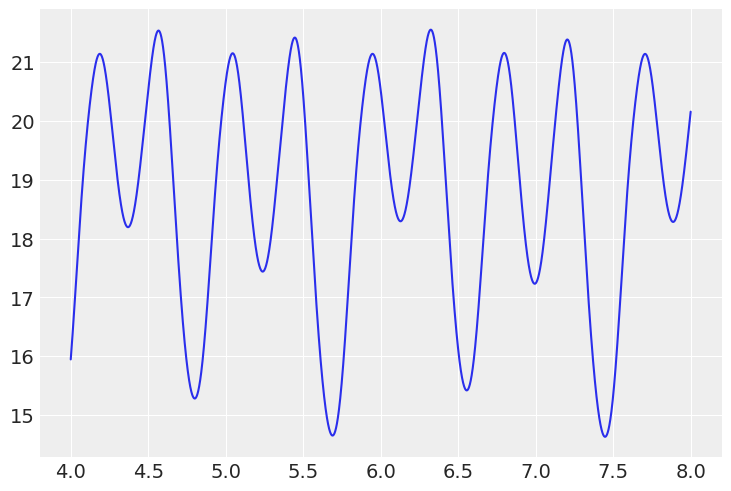

In [ ]:
plt.plot(t,E2)

In [ ]:
from scipy import integrate

In [ ]:
def f(x):
    return x**2

In [ ]:
E3 = []
Ederiv3 = [0]

for j in range(0,nt):
    E3.append(np.sqrt(integrate.simpson(u[:,j]**2,x)))
    
Ederiv3[0]= E3[0]
for j in range(1,nt-1):
    Ederiv3.append((E3[j+1]-E3[j])/dt)

transit = round(nt/2)
E3=E3[transit:nt-1]
Ederiv3=Ederiv3[transit:]

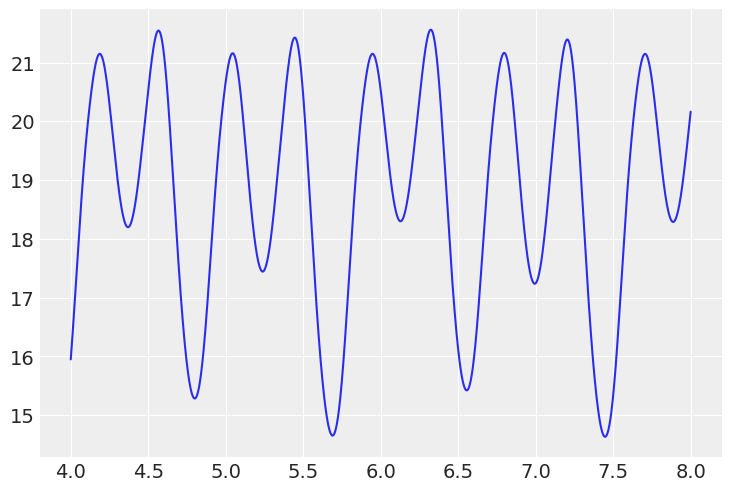

In [ ]:
plt.plot(t,E3)

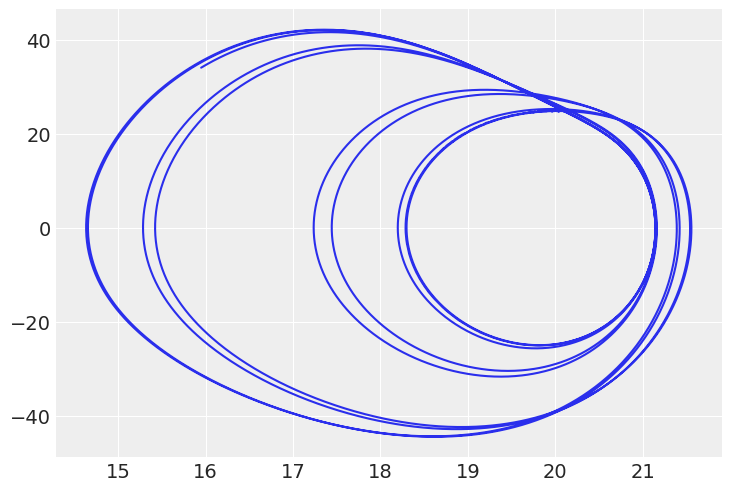

In [ ]:
plt.plot(E3,Ederiv3)